# Music Genre Classification

Classify the musical genre of a given audio track - from data to deployed model. Adapted from the work of Huang, Serafini, and Pugh [1].

## Authors
- Sebastian Lehrig <sebastian.lehrig1@ibm.com>
- Marvin Giessing <MARVING@de.ibm.com>

## License
Apache-2.0 License

## References
[1] original paper: http://cs229.stanford.edu/proj2018/report/21.pdf

[2] code: https://github.com/derekahuang/Music-Classification

[3] Preprocessed Data: https://drive.google.com/file/d/12mCgkvbmissLh2Vop0bp_t98G8QCaV1E/view?usp=sharing

## 0.) Imports & Constants

In [300]:
import IPython.display
import json
import kfp
from kfp.components import (
    InputPath,
    OutputPath
)
import kfp.dsl as dsl
from kfp.dsl import (
    PipelineConf,
    data_passing_methods
)
from kubernetes.client.models import (
    V1Volume,
    V1PersistentVolumeClaimVolumeSource
)
import librosa as lb
from librosa import display
import math
import numpy as np
import os
import pylab
import requests
from typing import NamedTuple

In [301]:
COMPONENT_CATALOG_FOLDER = f"{os.getenv('HOME')}/components"
COMPONENT_CATALOG_GIT = "https://github.com/ntl-ibm/kubeflow-ppc64le-components.git"
COMPONENT_CATALOG_RELEASE = "main"

LOAD_DATASET_COMPONENT = f"{COMPONENT_CATALOG_FOLDER}/data-collection/load-dataset/component.yaml"
TRAIN_MODEL_COMPONENT = f"{COMPONENT_CATALOG_FOLDER}/model-building/train-model-job/component.yaml"
PLOT_CONFUSION_MATRIX_COMPONENT = f"{COMPONENT_CATALOG_FOLDER}/model-building/plot-confusion-matrix/component.yaml"
CONVERT_MODEL_TO_ONNX_COMPONENT = f"{COMPONENT_CATALOG_FOLDER}/model-building/convert-to-onnx/component.yaml"
UPLOAD_MODEL_COMPONENT = f"{COMPONENT_CATALOG_FOLDER}/model-building/upload-model/component.yaml"
DEPLOY_MODEL_WITH_KSERVE_COMPONENT = f"{COMPONENT_CATALOG_FOLDER}/model-deployment/deploy-model-with-kserve/component.yaml"

BASE_IMAGE = "quay.io/ibm/kubeflow-notebook-image-ppc64le:elyra3.10.1-py3.8-tf2.8.0-v2"

ARGUMENTS = {
    'blackboard': 'artefacts',
    'dataset_url': 'Lehrig/GTZAN-Collection',
    'dataset_configuration': 'mel_spectrograms',
    'dataset_label_column': 'genre',
    'model_name': "music-classification",
    'minio_url': 'minio-service.kubeflow:9000',
    'minio_user': os.getenv('MINIO_ID'),
    'minio_pass': os.getenv('MINIO_PWD')
}
MODEL_NAME = ARGUMENTS["model_name"]

with open("/var/run/secrets/kubernetes.io/serviceaccount/namespace") as f:
    NAMESPACE = f.read()
NAMESPACE

'user-example-com'

## 1.) Let's start with creating a client object for interaction

In [302]:
client = kfp.Client()

## 2.) The main part consists of defining the end-to-end workflow functions and create components from them
### 2.0) Load component catalog

In [315]:
!git clone --branch $COMPONENT_CATALOG_RELEASE $COMPONENT_CATALOG_GIT $COMPONENT_CATALOG_FOLDER

fatal: destination path '/home/jovyan/components' already exists and is not an empty directory.


### 2.1) Load dataset (by reusing a Kubeflow component)

In [304]:
load_dataset_comp = kfp.components.load_component_from_file(
    LOAD_DATASET_COMPONENT
)

### 2.2) Preprocess data (one hot encoding etc.)

In [305]:
def preprocess_dataset(
    dataset_dir: InputPath(str),
    prep_dataset_dir: OutputPath(str),
    batch_size: int = 200,
):
    """Split data into train/dev/test data. Saves result into `prep_dataset_dir`."""

    from datasets import load_from_disk
    import numpy as np
    import os

    print(f'Loading input dataset from {dataset_dir}...')
    dataset = load_from_disk(dataset_dir)

    # Preprocess
    num_classes = dataset["train"].features["genre"].num_classes
    one_hot_matrix = np.eye(num_classes)

    def process(examples):
        examples["genre"] = [
            one_hot_matrix[genre] for genre in examples["genre"]
        ]
        return examples

    prep_dataset = dataset.map(
        process,
        batched=True,
        batch_size=batch_size,
        num_proc=2,
        keep_in_memory=True
    )

    prep_dataset = prep_dataset.with_format("numpy")

    print(f"Saving pre-processed dataset to '{prep_dataset_dir}'...")
    if not os.path.exists(prep_dataset_dir):
        os.makedirs(prep_dataset_dir)
    prep_dataset.save_to_disk(prep_dataset_dir)
    print(f"Pre-processed Dataset saved. Contents of '{dataset_dir}':")
    print(os.listdir(dataset_dir))

    print('Finished.')


preprocess_dataset_comp = kfp.components.create_component_from_func(
    func=preprocess_dataset,
    base_image=BASE_IMAGE
)

### 2.3) Train the model

In [306]:
def train_model(
    prep_dataset_dir: InputPath(str),
    model_dir: OutputPath(str),
    epochs: int = 100,
    batch_size: int = 200
):
    """Trains CNN model. Once trained, the model is persisted to `model_dir`."""

    from datasets import load_from_disk
    import os
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import (
        BatchNormalization,
        Conv2D,
        Dense,
        Dropout,
        Flatten,
        MaxPooling2D
    )
    from tensorflow.keras import regularizers
    import time
    from transformers import DefaultDataCollator

    model = Sequential()

    # Feature Learning Layers
    model.add(Conv2D(64,
                     kernel_size=(4, 4),
                     activation='relu',
                     kernel_regularizer=regularizers.l2(0.04),
                     input_shape=(64, 173, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 4)))

    model.add(Conv2D(64, (3, 5), activation='relu', kernel_regularizer=regularizers.l2(0.04)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (2, 2), activation='relu', kernel_regularizer=regularizers.l2(0.04)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    # Classification Layers
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.04)))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.04)))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
                  metrics=[tf.keras.metrics.categorical_accuracy])
    print(model.summary())

    dataset = load_from_disk(prep_dataset_dir)

    data_collator = DefaultDataCollator(return_tensors="tf")

    train_dataset = dataset["train"].to_tf_dataset(
        columns=['mel_spectrogram'],
        label_cols=['genre'],
        shuffle=True,
        batch_size=batch_size,
        collate_fn=data_collator
    )

    validation_dataset = dataset["validation"].to_tf_dataset(
        columns=['mel_spectrogram'],
        label_cols=['genre'],
        shuffle=False,
        batch_size=batch_size,
        collate_fn=data_collator
    )

    # see: https://github.com/huggingface/datasets/issues/4478
    tf.data.experimental.save(train_dataset, "./train")
    tf.data.experimental.save(validation_dataset, "./val")
    train_dataset = tf.data.experimental.load("./train")
    validation_dataset = tf.data.experimental.load("./val")

    start = time.time()
    hist = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=epochs)
    print("\n\nTraining took ", time.time()-start, "seconds")

    print("Model train history:")
    print(hist.history)

    print(f"Saving model to: {model_dir}")
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model.save(model_dir)
    print(f"Model saved to: {model_dir}")

    print('Finished.')


train_specification = kfp.components.func_to_component_text(
    func=train_model
)

In [307]:
train_model_comp = kfp.components.load_component_from_file(
    TRAIN_MODEL_COMPONENT
)

### 2.4) Evaluate model with validation data

In [308]:
def evaluate_model(
    prep_dataset_dir: InputPath(str),
    model_dir: InputPath(str),
    batch_size: int = 20
) -> NamedTuple(
        "EvaluationOutput", [
            ("mlpipeline_metrics", "Metrics")
        ]):
    """Loads a saved model from file and uses a pre-downloaded dataset for evaluation.
    Model metrics are persisted to `{metrics_path}` for Kubeflow Pipelines metadata."""

    from collections import namedtuple
    from datasets import load_from_disk
    import json
    import tensorflow as tf
    from transformers import DefaultDataCollator

    dataset = load_from_disk(prep_dataset_dir)
    data_collator = DefaultDataCollator(return_tensors="tf")
    test_dataset = dataset["test"].to_tf_dataset(
        columns=['mel_spectrogram'],
        label_cols=['genre'],
        shuffle=False,
        batch_size=batch_size,
        collate_fn=data_collator
    )
    # see: https://github.com/huggingface/datasets/issues/4478
    tf.data.experimental.save(test_dataset, "./test")
    test_dataset = tf.data.experimental.load("./test")

    model = tf.keras.models.load_model(model_dir)
    (loss, accuracy) = model.evaluate(test_dataset)

    print((loss, accuracy))

    metrics = {
        "metrics": [
            {
                "name": "loss",
                "numberValue": str(loss),
                "format": "PERCENTAGE"
            },
            {
                "name": "accuracy",
                "numberValue": str(accuracy),
                "format": "PERCENTAGE"},
        ]
    }

    out_tuple = namedtuple("EvaluationOutput", ["mlpipeline_metrics"])

    return out_tuple(json.dumps(metrics))


evaluate_model_comp = kfp.components.create_component_from_func(
    func=evaluate_model,
    base_image=BASE_IMAGE
)

### 2.5) Create confusion matrix (by reusing a Kubeflow component)

In [309]:
plot_confusion_matrix_comp = kfp.components.load_component_from_file(
    PLOT_CONFUSION_MATRIX_COMPONENT
)

### 2.6) Convert model to ONNX (by reusing a Kubeflow component)

In [310]:
convert_model_to_onnx_comp = kfp.components.load_component_from_file(
    CONVERT_MODEL_TO_ONNX_COMPONENT
)

### 2.7) Upload model to MinIO artifact store (by reusing a Kubeflow component)

In [311]:
upload_model_comp = kfp.components.load_component_from_file(
    UPLOAD_MODEL_COMPONENT
)

### 2.8) Deploy the model using KServe (by reusing a Kubeflow component)

In [312]:
deploy_model_with_kserve_comp = kfp.components.load_component_from_file(
    DEPLOY_MODEL_WITH_KSERVE_COMPONENT
)

## 3.) Create the actual pipeline by combining the components

In [313]:
@dsl.pipeline(
  name='Music Genre Classification',
  description='An example pipeline that performs a music genre classification on audio data'
)
def music_genre_classification_pipeline(
            blackboard: str,
            dataset_url: str,
            dataset_configuration: str,
            dataset_label_column: str,
            model_name: str,
            minio_url: str,
            minio_user: str,
            minio_pass: str):
    create_blackboard = dsl.VolumeOp(
        name='Create Artefacts Blackboard',
        resource_name=blackboard,
        modes=dsl.VOLUME_MODE_RWO,
        size="4Gi",
        set_owner_reference=True
    )
    
    create_training_volume = dsl.VolumeOp(
        name='Create Training Volume',
        resource_name="training-volume",
        modes=dsl.VOLUME_MODE_RWM,
        size="4Gi",
        set_owner_reference=True
    )

    load_dataset_task = load_dataset_comp(
        path=dataset_url,
        configuration=dataset_configuration,
        label_column=dataset_label_column
    )
    load_dataset_task.after(create_blackboard)

    preprocess_dataset_task = preprocess_dataset_comp(
        load_dataset_task.outputs['dataset_dir'],
    )

    # InputPath and OutputPath like "prep_dataset_dir" & "model_dir":
    # Use name of parameters of train component on right-hand side.
    train_parameters = {
        "prep_dataset_dir": "dataset_directory",
        "model_dir": "model_dir",
    }

    train_mount = "/train"
    train_model_task = train_model_comp(
        preprocess_dataset_task.outputs['prep_dataset_dir'],
        train_specification,
        train_parameters,
        train_mount,
        model_name=model_name,
        pvc_name=create_training_volume.volume.persistent_volume_claim.claim_name,
        gpus=1,
        node_selector='nvidia.com/gpu.product: "Tesla-V100-SXM2-32GB"',
    ).add_pvolumes({train_mount: create_training_volume.volume})

    evaluate_model_comp(
        preprocess_dataset_task.outputs['prep_dataset_dir'],
        train_model_task.outputs['model_dir']
    )

    plot_confusion_matrix_comp(
        "mel_spectrogram",
        "genre",
        preprocess_dataset_task.outputs['prep_dataset_dir'],
        train_model_task.outputs['model_dir'],
        load_dataset_task.outputs['labels']
    )

    convert_model_to_onnx_task = convert_model_to_onnx_comp(
        train_model_task.outputs['model_dir']
    )

    upload_model_task = upload_model_comp(
        convert_model_to_onnx_task.outputs['onnx_model_dir'],
        minio_url,
        minio_user,
        minio_pass,
        model_name=model_name
    )

    deploy_model_with_kserve_task = deploy_model_with_kserve_comp(
        model_name=model_name
    )

    deploy_model_with_kserve_task.after(upload_model_task)

## 4.) Run the pipeline within an experiment
Create a pipeline run, using the client you initialized in a prior step.

In [314]:
pipeline_conf = PipelineConf()
pipeline_conf.data_passing_method = data_passing_methods.KubernetesVolume(
    volume=V1Volume(
        name=ARGUMENTS["blackboard"],
        persistent_volume_claim=V1PersistentVolumeClaimVolumeSource(
            "{{workflow.name}}-%s" % ARGUMENTS["blackboard"]
        ),
    ),
    path_prefix=f'{ARGUMENTS["blackboard"]}/',
)

client.create_run_from_pipeline_func(
    music_genre_classification_pipeline,
    arguments=ARGUMENTS,
    namespace=NAMESPACE,
    pipeline_conf=pipeline_conf
)

RunPipelineResult(run_id=a9b2aaad-860c-4344-ba0a-0a27bec59a93)

## 5.) Test model deployment
See API documentation: https://github.com/kserve/kserve/blob/master/docs/predict-api/v2/required_api.md

### 5.1) Check model endpoint availability

In [283]:
HOST = MODEL_NAME + "-predictor-default." + NAMESPACE
HEADERS = {'Host': HOST}
MODEL_ENDPOINT = "http://" + MODEL_NAME + "-predictor-default/v2/models/" + MODEL_NAME

res = requests.get(MODEL_ENDPOINT, headers=HEADERS)
response = json.loads(res.text)
response

{'name': 'music-classification',
 'versions': ['1'],
 'platform': 'onnxruntime_onnx',
 'inputs': [{'name': 'conv2d_input',
   'datatype': 'FP32',
   'shape': [-1, 64, 173, 1]}],
 'outputs': [{'name': 'dense_2', 'datatype': 'FP32', 'shape': [-1, 10]}]}

Note you can also do this:
```curl -H "Host: $HOST" $MODEL_ENDPOINT```

### 5.2) Get test audio
See: https://commons.wikimedia.org/wiki/Category:Audio_files_of_blues

In [115]:
AUDIO = "audio.ogg"

AUDIO_URL = "https://upload.wikimedia.org/wikipedia/commons/7/7c/Boogie_lead_riff.ogg"
#AUDIO_URL = "https://upload.wikimedia.org/wikipedia/commons/9/99/Blues_Rock.ogg"

!wget $AUDIO_URL -O $AUDIO

--2022-06-13 19:35:23--  https://upload.wikimedia.org/wikipedia/commons/7/7c/Boogie_lead_riff.ogg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 136778 (134K) [application/ogg]
Saving to: ‘audio.ogg’

audio.ogg           100%[===================>] 133.57K  --.-KB/s    in 0.09s   

2022-06-13 19:35:23 (1.44 MB/s) - ‘audio.ogg’ saved [136778/136778]



In [116]:
IPython.display.Audio(AUDIO)

### 5.3) Convert test audio to 2-seconds Mel Spectrograms

In [117]:
SR = 22050
N_FFT = 512
HOP_LENGTH = N_FFT // 2
N_MELS = 64


def convert_to_melspecs(filename):
    audios = get_batches(filename)
    return batch_log_melspectrogram(audios)


def get_batches(audio):
    y, sr = lb.load(audio, mono=True)

    duration = lb.core.get_duration(y)

    audios = []
    # prune first 2 seconds and ending (assumption: does not include important data)
    for i in range(2, math.floor(duration), 2):
        y_sample, sr_sample = lb.load(audio, mono=True, offset=i, duration=2.0)
        audios.append(y_sample)

    return audios


def log_melspectrogram(data):
    melspec = lb.feature.melspectrogram(
        y=data,
        hop_length=HOP_LENGTH,
        n_fft=N_FFT,
        n_mels=N_MELS)
    return lb.power_to_db(melspec**2)


def batch_log_melspectrogram(data_list):
    melspecs = np.asarray([
        log_melspectrogram(data_list[i]) for i in range(len(data_list)-1)
    ])
    melspecs = melspecs.reshape(
        melspecs.shape[0],
        melspecs.shape[1],
        melspecs.shape[2],
        1
    )
    return melspecs


melspecs = convert_to_melspecs(AUDIO)

/tmp/ipykernel_1677/3707286731.py:15: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00010085  0.00037511
  0.00036228] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = lb.core.get_duration(y)


### 5.4) Visualize a Mel Spectrogram

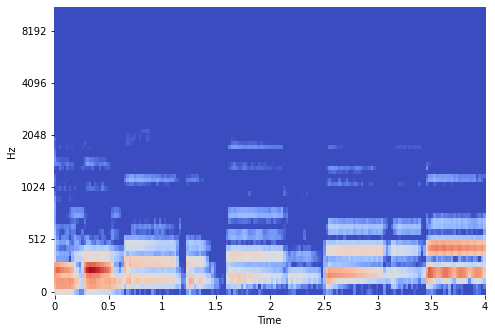

In [118]:
middle = (int)(melspecs.shape[0]/2)
example_melspec = melspecs[middle]
example_melspec = example_melspec.reshape(example_melspec.shape[0], example_melspec.shape[1])

pylab.axis('off')  # no axis
pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])  # Remove the white edge
display.specshow(example_melspec, y_axis='mel', x_axis='time')

### 5.5) Score example Mel Spectromgram against model 

In [119]:
def score(melspec):
    PREDICT_ENDPOINT = MODEL_ENDPOINT + "/infer"

    payload = {
      "inputs": [{
          "name": "conv2d_input",
          "shape": [1, 64, 173, 1],
          "datatype": "FP32",
          "data": melspec.tolist()
        }
      ]
    }

    res = requests.post(PREDICT_ENDPOINT, headers=HEADERS, data=json.dumps(payload))
    response = json.loads(res.text)
    return response['outputs'][0]['data']


test_score = score(example_melspec)
test_score

[0.34647268056869507,
 0.00966434832662344,
 0.09250146150588989,
 0.05835621803998947,
 0.06629616767168045,
 0.05328315868973732,
 0.02180309221148491,
 0.0657801404595375,
 0.18143512308597565,
 0.10440760105848312]

In [120]:
GENRE_LABELS = [
    "Blues",
    "Classical",
    "Country",
    "Disco",
    "Hip hop",
    "Jazz",
    "Metal",
    "Pop",
    "Reggae",
    "Rock"
]

GENRE_LABELS[np.argmax(test_score)]

'Blues'

### 5.6) Score each Mel Spectrogram against deployed model & aggregate results

In [121]:
probabilities = [0.0 for genre in GENRE_LABELS]
counts = [0 for genre in GENRE_LABELS]

for melspec in melspecs:
    predictions = score(melspec)
    for i in range(len(GENRE_LABELS)):
        probabilities[i] += predictions[i]
    counts[np.argmax(predictions)] += 1

### 5.7) Aggregate results

In [122]:
for i in range(len(GENRE_LABELS)):
    probabilities[i] = probabilities[i]/len(melspecs)
    print(GENRE_LABELS[i] + ": " + str(probabilities[i]) + " (" + str(counts[i]) + "x)")

Blues: 0.3577570567528407 (6x)
Classical: 0.009151351269489775 (0x)
Country: 0.08345471570889156 (0x)
Disco: 0.05507979138443867 (0x)
Hip hop: 0.07157800532877445 (0x)
Jazz: 0.04526779831697544 (0x)
Metal: 0.020703535759821534 (0x)
Pop: 0.06786082188288371 (0x)
Reggae: 0.1887275849779447 (0x)
Rock: 0.10041932513316472 (0x)
